# 1. Import Packages

PIL Image로는 X server가 없다며 이미지를 안보여준다.
IPython.display의 Image를 통해 이미지 확인

In [18]:
from transformers import(
    VisionEncoderDecoderModel, 
    ViTFeatureExtractor, 
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedTokenizerFast
)
import torch
import numpy as np
from PIL import Image
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from IPython.display import Image as Image2See

# 2. Captioning Model 불러오기


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# load captioning model
encoder_model_name_or_path = "ddobokki/vision-encoder-decoder-vit-gpt2-coco-ko"
caption_tokenizer = PreTrainedTokenizerFast.from_pretrained(encoder_model_name_or_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_model_name_or_path)
caption_model = VisionEncoderDecoderModel.from_pretrained(encoder_model_name_or_path)

# 3. Poem Model 불러오기
청계산 셰르파 org에서 불러온다. transformers-cli login을 실행해 권한을 받아오는 것이 필요함.

In [ ]:
#!transformers-cli login

In [5]:
# load poem model
path = "CheonggyeMountain-Sherpa/kogpt-trinity-poem"
poem_model = AutoModelForCausalLM.from_pretrained(path, use_auth_token=True) 
poem_tokenizer = AutoTokenizer.from_pretrained(path, use_auth_token=True)

# 4. Image2Poem Module을 통해 하나로 연결
forward로 위 두 모델을 연결한다.

MSCOCO 이미지 데이터셋의 img path를 모델에 넣어주면 해당 이미지를 로드하고

캡션 모델을 통해 캡션을 뽑아낸 후,

그 캡션으로 시를 생성한다.

image_path[str] -> poem[str]

In [38]:
class Image2Poem(torch.nn.Module):
    def __init__(self, feature_extractor, caption_model, caption_tokenizer, poem_model, poem_tokenizer):
        super(Image2Poem, self).__init__()
        self.feature_extractor = feature_extractor
        self.caption_model = caption_model
        self.caption_tokenizer = caption_tokenizer
        self.poem_model = poem_model
        self.poem_tokenizer = poem_tokenizer
    
    def forward(self, filepath_for_image):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        image = Image.open(filepath_for_image).convert("RGB")
        image_tensor = np.array(image)
        pixel_values = self.feature_extractor(image_tensor, return_tensors="pt").pixel_values.to(device)
        generated_ids = self.caption_model.generate(pixel_values, num_beams=5)
        caption = self.caption_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        prompt = self.poem_tokenizer.encode(caption, return_tensors="pt").to(device)
        poem_output = self.poem_model.generate(
            prompt,
            max_length=60,
            repetition_penalty=2.0,
            pad_token_id=self.poem_tokenizer.pad_token_id,
            eos_token_id=self.poem_tokenizer.eos_token_id,
            bos_token_id=self.poem_tokenizer.bos_token_id,
            do_sample=True,
            top_k=30,
            top_p=0.95
        )
        poem = self.poem_tokenizer.decode(poem_output[0])
        return poem

In [39]:
prototype_model = Image2Poem(feature_extractor, caption_model, caption_tokenizer, poem_model, poem_tokenizer).to(device)
prototype_model.eval()

Image2Poem(
  (caption_model): VisionEncoderDecoderModel(
    (encoder): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (int

# 5. 데이터셋 불러오기
**주의할 점: 환경에 따라 아래 두 path 변수를 변경해준다**

data_path는 train2014, valid2014가 있는 경로

In [ ]:
coco_json_path = '/opt/ml/final-project-level3-nlp-08/MSCOCO_train_val_Korean.json'
data_path = '/opt/ml/final-project-level3-nlp-08/'

In [9]:
with open(coco_json_path, 'r') as f:
    coco = json.load(f)
    
img_path = []
total_caption_lst = []
for i in range(len(coco)):
    # 캡션 5개 미만이면 추가하지 않음
    if len(coco[i]['caption_ko']) < 5:
        continue
    # img path 추가
    img_path.append(data_path + coco[i]['file_path'])

    # img path와 매칭되는 caption 5개 추가
    caption_lst = []
    for j in range(5):
        caption_lst.append(coco[i]['caption_ko'][j])
    total_caption_lst.append(caption_lst)

In [10]:
coco_df = pd.DataFrame(data={
    'labels': total_caption_lst,
    'img_paths': img_path
})

In [11]:
coco_data = coco_df
train_df, val_df = train_test_split(coco_data, test_size=0.2, random_state=42)
val_df = val_df.reset_index()
img, label = val_df['img_paths'], val_df['labels']

In [33]:
#index = 66
index = 270

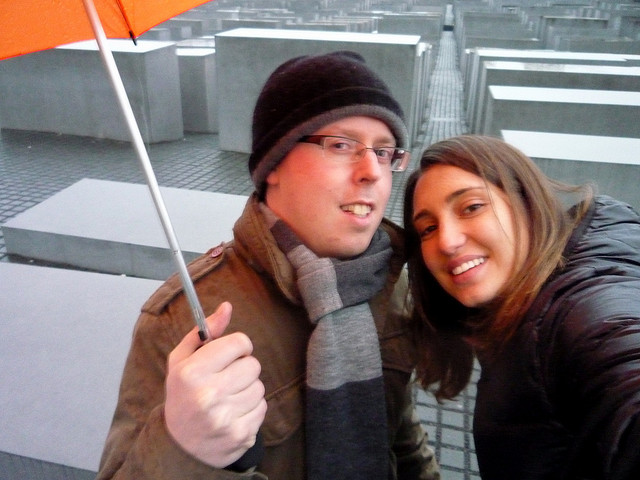

'우산을 들고 있는 남자와 여자. 비오는 날이면 사람들은 저 남자가 여자를 안으려 한다며 소리쳐댔다. 남자에게는 여자의 뒷모습이 보이지 않는다. 여자는 남자의 옆얼굴을 볼 수 없었다. 비는 오지않는데 남자는 왜 저렇게 혼자 서 있을까... 창밖에 비가 내리고 있었다. 그녀는 그렇게 생각했다. 나는 그녀의'

In [41]:
display(Image2See(filename=img[index]))
prototype_model(img[index])